In [1]:
import numpy as np
import time
import pygame

import gymnasium as gym
from gymnasium import Env, spaces


pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
MAP = [
    "+---------+",
    "|R: | : :G|",
    "| :C| : :M|",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)
FRAME_RATE = 10 # Frames per second
DELAY = 0.1  # Delay in seconds

class MultiAgentTaxiEnv(Env):
    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": FRAME_RATE,
    }

    def __init__(self, render_mode=None, num_agents=2, num_tasks=3):
        self.desc = np.asarray(MAP, dtype="c")
        self.num_agents = num_agents
        self.num_tasks = num_tasks

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (1, 5)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255)]

        self.action_space = spaces.MultiDiscrete([6] * self.num_agents)
        self.observation_space = spaces.Dict({
            'agents': spaces.Box(low=0, high=4, shape=(self.num_agents, 3), dtype=np.int32),  # [x, y, carrying]
            'tasks': spaces.MultiDiscrete([5, 5, 5, 5] * self.num_tasks)  # [pickup_x, pickup_y, dropoff_x, dropoff_y] * num_tasks
        })

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)
        self.agents[:, :2] = np.random.randint(0, 5, (self.num_agents, 2))

        self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)
        for i in range(self.num_tasks):
            pickup_loc = self.locs[np.random.randint(0, len(self.locs))]
            dropoff_loc = self.locs[np.random.randint(0, len(self.locs))]
            while dropoff_loc == pickup_loc:
                dropoff_loc = self.locs[np.random.randint(0, len(self.locs))]
            self.tasks[i] = np.array([pickup_loc[0], pickup_loc[1], dropoff_loc[0], dropoff_loc[1]])

        return self._get_obs()

    def _get_obs(self):
        return {
            'agents': self.agents,
            'tasks': self.tasks
        }

    def step(self, actions):
        assert self.action_space.contains(actions), f"Invalid action: {actions}"
        
        rewards = np.zeros(self.num_agents)
        terminated = False
        truncated = False
        
        for i in range(self.num_agents):
            if actions[i] == 0:  # Move up
                self.agents[i, 1] = min(self.agents[i, 1] + 1, 4)
            elif actions[i] == 1:  # Move down
                self.agents[i, 1] = max(self.agents[i, 1] - 1, 0)
            elif actions[i] == 2:  # Move left
                self.agents[i, 0] = max(self.agents[i, 0] - 1, 0)
            elif actions[i] == 3:  # Move right
                self.agents[i, 0] = min(self.agents[i, 0] + 1, 4)
            elif actions[i] == 4:  # Pick up task
                for task_id, task in enumerate(self.tasks):
                    if np.array_equal(self.agents[i, :2], task[:2]) and self.agents[i, 2] == 0:
                        self.agents[i, 2] = task_id + 1  # Carry task_id + 1
            elif actions[i] == 5:  # Drop off task
                task_id = self.agents[i, 2] - 1
                if task_id >= 0 and np.array_equal(self.agents[i, :2], self.tasks[task_id, 2:]):
                    rewards[i] += 20
                    self.tasks[task_id] = np.array([-1, -1, -1, -1])  # Invalidate the task
                    self.agents[i, 2] = 0  # No longer carrying task
            
            # Penalize for each step to encourage efficiency
            rewards[i] -= 1

        # Check if all tasks are completed
        if all(self.tasks[:, 0] == -1):
            terminated = True

        return self._get_obs(), rewards, terminated, truncated, {}

    def render(self, mode='human'):
        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Multi-Agent Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)
        
        assert (
            self.window is not None
        ), "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.taxi_imgs is None:
            file_names = [
                "img/cab_front.png",
                "img/cab_rear.png",
                "img/cab_right.png",
                "img/cab_left.png",
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = "img/passenger.png"
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = "img/hotel.png"
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                "img/gridworld_median_left.png",
                "img/gridworld_median_horiz.png",
                "img/gridworld_median_right.png",
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                "img/gridworld_median_top.png",
                "img/gridworld_median_vert.png",
                "img/gridworld_median_bottom.png",
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = "img/taxi_background.png"
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        for agent in self.agents:
            self.window.blit(self.taxi_imgs[0], self.get_surf_loc((agent[0], agent[1])))

        for task in self.tasks:
            if task[0] != -1:
                self.window.blit(self.passenger_img, self.get_surf_loc((task[0], task[1])))
                self.window.blit(self.destination_img, self.get_surf_loc((task[2], task[3])))
        
        pygame.display.flip()

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

In [3]:
env = MultiAgentTaxiEnv(render_mode="human", num_agents=2, num_tasks=3)
obs = env.reset()
done = False

DELAY = 0.1

while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    time.sleep(DELAY)

env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -795     |
| time/              |          |
|    fps             | 874      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -776         |
| time/                   |              |
|    fps                  | 759          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0011822459 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    e

KeyboardInterrupt: 

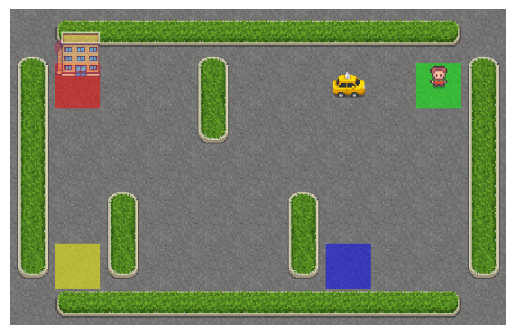